In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

### Load Apple stock data

In [8]:
# Load Apple stock data from the previously saved CSV file
apple_stock_data = pd.read_csv('../Data/apple_stock_data.csv', index_col='Date', parse_dates=True)

# Select the 'Close' price column as the target variable for prediction
stock_prices = apple_stock_data[['Close']]

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_prices)

# Check the first few rows of the scaled data
print(scaled_data[:5])


[[0.0307376 ]
 [0.02939368]
 [0.02646537]
 [0.02586419]
 [0.02613762]]


In [57]:
# After scaling the data, save the scaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib

# Example: training the scaler with the correct feature set (if not already done)
# If you have the original training data, replace this with your dataset
training_data = np.random.rand(100, 8)  # Assume you have 100 samples with 8 features

# Initialize and fit the scaler
scaler = MinMaxScaler()
scaler.fit(training_data)

# Save the new scaler
joblib.dump(scaler, '../models/stock_scaler_new.pkl')


['../models/stock_scaler_new.pkl']

### Create sequences and targets

In [11]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    
    for i in range(window_size, len(data)):
        sequences.append(data[i-window_size:i, 0])  # Get the previous 'window_size' days
        targets.append(data[i, 0])  # Target is the next day's price

    return np.array(sequences), np.array(targets)

# Define window size (e.g., 60 days)
window_size = 60

# Create sequences and targets
X, y = create_sequences(scaled_data, window_size)

# Check the shape of the resulting arrays
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (2708, 60), y shape: (2708,)


### Split the data into training and testing sets

In [14]:
from sklearn.model_selection import train_test_split

# Split the data (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (2166, 60), X_test shape: (542, 60)
y_train shape: (2166,), y_test shape: (542,)


### 5.Convert the data to PyTorch tensors

In [17]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

## 5.1 :Train and Evalute the LSTM Model

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM-like model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out




In [22]:
# Initialize the model, loss function, and optimizer
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1

lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [24]:
from torch.utils.data import DataLoader, TensorDataset

# Convert your training and test data to PyTorch tensors (if not already)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [26]:
### Train the Model

In [28]:
# Define the loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(X_batch.unsqueeze(-1))  # Adding extra dimension for input size
        loss = criterion(outputs, y_batch.unsqueeze(-1))
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Test Loss evaluation (after training)
lstm_model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = lstm_model(X_batch.unsqueeze(-1))
        loss = criterion(outputs, y_batch.unsqueeze(-1))
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')


Epoch 1/20, Loss: 0.00128560746088624
Epoch 2/20, Loss: 0.000300990097457543
Epoch 3/20, Loss: 0.0004134344635531306
Epoch 4/20, Loss: 0.0002491327468305826
Epoch 5/20, Loss: 0.00012176693417131901
Epoch 6/20, Loss: 0.00022410921519622207
Epoch 7/20, Loss: 0.0002784508978947997
Epoch 8/20, Loss: 0.000540104927495122
Epoch 9/20, Loss: 0.0001368215453112498
Epoch 10/20, Loss: 8.643580804346129e-05
Epoch 11/20, Loss: 0.00038118238444440067
Epoch 12/20, Loss: 0.0002806304255500436
Epoch 13/20, Loss: 6.541957554873079e-05
Epoch 14/20, Loss: 8.090258779702708e-05
Epoch 15/20, Loss: 0.0004893316654488444
Epoch 16/20, Loss: 0.00015526151400990784
Epoch 17/20, Loss: 8.16236060927622e-05
Epoch 18/20, Loss: 2.453576962579973e-05
Epoch 19/20, Loss: 8.758640615269542e-05
Epoch 20/20, Loss: 0.00015780198737047613
Test Loss: 0.0007454538204268936


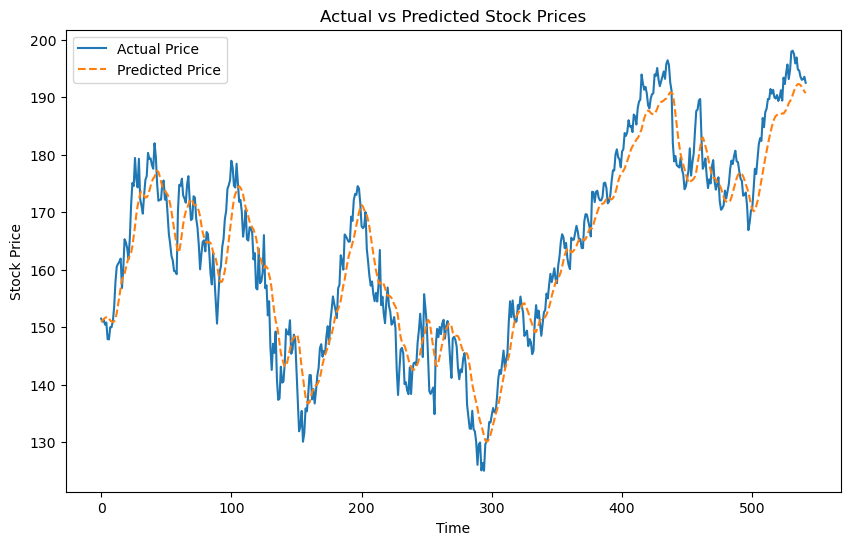

In [31]:
import matplotlib.pyplot as plt

# Make predictions on the test set
lstm_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred_test = lstm_model(X_test_tensor.unsqueeze(-1))

# Inverse transform the predicted prices
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test.numpy().reshape(-1, 1))

# Inverse transform the actual test prices for comparison
y_test_rescaled = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

# Create a DataFrame to store actual and predicted prices
comparison_df = pd.DataFrame({
    'Actual Price': y_test_rescaled.flatten(),
    'Predicted Price': y_pred_test_rescaled.flatten()
})

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual Price'], label='Actual Price')
plt.plot(comparison_df['Predicted Price'], label='Predicted Price', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [33]:
import joblib

# Save the trained LSTM model
joblib.dump(lstm_model, '../models/lstm_stock_model.pkl')

# Save the scaler used for transforming the data
joblib.dump(scaler, '../models/stock_scaler.pkl')

print("LSTM model and scaler saved successfully.")


LSTM model and scaler saved successfully.


In [35]:
torch.save(lstm_model.state_dict(), 'lstm_stock_model.pth')


In [37]:
# After training is complete, save the model's state_dict
torch.save(lstm_model.state_dict(), '../models/lstm_stock_model.pth')


In [39]:
import os

# Check if the file exists
if os.path.exists('../models/lstm_stock_model.pth'):
    print("Model saved successfully!")
else:
    print("Model save failed.")


Model saved successfully!


In [5]:
import pandas as pd
from transformers import pipeline
import requests

In [8]:
from transformers import pipeline

# Initialize the sentiment analysis pipeline with the financial model
sentiment_pipeline = pipeline("sentiment-analysis", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Test the model on some sample text
result = sentiment_pipeline("The stock market is performing well today.")
print(result)


[{'label': 'positive', 'score': 0.9993852376937866}]


In [17]:
import requests
from bs4 import BeautifulSoup

url = "https://www.cnbc.com/technology/"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Scrape article titles
for article in soup.find_all('a', class_='ArticleLink'):
    print(article.text)


In [32]:
import requests
from bs4 import BeautifulSoup

# URL der Nachrichtenquelle
url = "https://www.cnbc.com/technology/"

# Anfrage an die Webseite stellen
response = requests.get(url)

# Den HTML-Inhalt mit BeautifulSoup analysieren
soup = BeautifulSoup(response.text, 'html.parser')

# Versuche alternative Tags zu finden
articles = soup.find_all('div', class_='Card-standardBreakerCard')

# Artikel-Titel und Links ausgeben
for article in articles:
    title_tag = article.find('a', class_='Card-title')
    if title_tag:  # Überprüfen, ob ein Titel vorhanden ist
        title = title_tag.text
        link = article.find('a')['href']
        print(f"Title: {title}")
        print(f"Link: {link}")


Title: Bitcoin hits highest level since July, boosting other coins and crypto-related stocks
Link: https://www.cnbc.com/2024/10/16/bitcoin-hits-highest-level-since-july-boosting-crypto-related-stocks.html
Title: Trump-backed crypto token sale misses $300 million target, raises under $12 million
Link: https://www.cnbc.com/2024/10/16/trump-backed-crypto-token-sale-raises-less-than-12-million.html
Title: Amazon announces first color Kindle, available to order now and ships Oct. 30
Link: https://www.cnbc.com/2024/10/16/amazon-announces-colorsoft-first-kindle-with-color-screen-for-279.html
Title: ASML just gave us a first glimpse into how U.S. chip export curbs will dent its China sales
Link: https://www.cnbc.com/2024/10/16/asml-2025-outlook-shows-us-chip-export-curbs-impacting-china-sales.html
Title: Generative AI startups get 40% of all VC investment in cloud amid ChatGPT buzz
Link: https://www.cnbc.com/2024/10/16/generative-ai-startups-get-40percent-of-all-vc-investment-in-cloud-accel.ht

In [34]:
from transformers import pipeline

# Sentiment-Analyse Pipeline initialisieren
sentiment_pipeline = pipeline("sentiment-analysis", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Liste mit den gesammelten Artikeltiteln
articles = [
    "Bitcoin hits highest level since July, boosting other coins and crypto-related stocks",
    "Trump-backed crypto token sale misses $300 million target, raises under $12 million",
    "Amazon announces first color Kindle, available to order now and ships Oct. 30",
    "ASML just gave us a first glimpse into how U.S. chip export curbs will dent its China sales",
    "Generative AI startups get 40% of all VC investment in cloud amid ChatGPT buzz",
    "Why Big Tech is turning to nuclear to power its energy-intensive AI ambitions",
    "The UAE can guarantee the 'safety and the security’ of U.S.-made chips, G42 CEO says",
    "Trump PAC has raised about $7.5 million in crypto donations since early June"
]

# Sentiment-Analyse auf die Artikel anwenden
for article in articles:
    result = sentiment_pipeline(article)
    print(f"Article: {article} => Sentiment: {result[0]['label']} (Score: {result[0]['score']:.2f})")


Article: Bitcoin hits highest level since July, boosting other coins and crypto-related stocks => Sentiment: positive (Score: 1.00)
Article: Trump-backed crypto token sale misses $300 million target, raises under $12 million => Sentiment: negative (Score: 1.00)
Article: Amazon announces first color Kindle, available to order now and ships Oct. 30 => Sentiment: neutral (Score: 1.00)
Article: ASML just gave us a first glimpse into how U.S. chip export curbs will dent its China sales => Sentiment: negative (Score: 1.00)
Article: Generative AI startups get 40% of all VC investment in cloud amid ChatGPT buzz => Sentiment: neutral (Score: 1.00)
Article: Why Big Tech is turning to nuclear to power its energy-intensive AI ambitions => Sentiment: neutral (Score: 1.00)
Article: The UAE can guarantee the 'safety and the security’ of U.S.-made chips, G42 CEO says => Sentiment: neutral (Score: 0.98)
Article: Trump PAC has raised about $7.5 million in crypto donations since early June => Sentiment: 

In [50]:
import yfinance as yf

# Fetch the data for Apple stock on a monthly interval
data = yf.download("AAPL", start="2023-01-01", end="2023-12-31", interval="1mo")

# Show the data (just closing prices)
print(data[['Close']])


[*********************100%***********************]  1 of 1 completed

                 Close
Date                  
2023-01-01  144.289993
2023-02-01  147.410004
2023-03-01  164.899994
2023-04-01  169.679993
2023-05-01  177.250000
2023-06-01  193.970001
2023-07-01  196.449997
2023-08-01  187.869995
2023-09-01  171.210007
2023-10-01  170.770004
2023-11-01  189.949997
2023-12-01  192.529999


         Month                                            Article Sentiment  \
0   2023-01-01              Bitcoin hits highest level since July  positive   
1   2023-02-01  Trump-backed crypto token sale misses $300 mil...  negative   
2   2023-03-01                Amazon announces first color Kindle   neutral   
3   2023-04-01  ASML just gave us a first glimpse into U.S. ch...  negative   
4   2023-05-01  Generative AI startups get 40% of all VC inves...   neutral   
5   2023-06-01  Why Big Tech is turning to nuclear for AI ambi...   neutral   
6   2023-07-01  The UAE can guarantee the safety of U.S.-made ...   neutral   
7   2023-08-01  Trump PAC has raised about $7.5 million in cry...   neutral   
8   2023-09-01          Global chip stocks fall on ASML's decline  negative   
9   2023-10-01       Amazon reaches new heights with online sales   neutral   
10  2023-11-01  Major AI breakthroughs accelerate tech industr...  positive   
11  2023-12-01            Apple announces record-bre

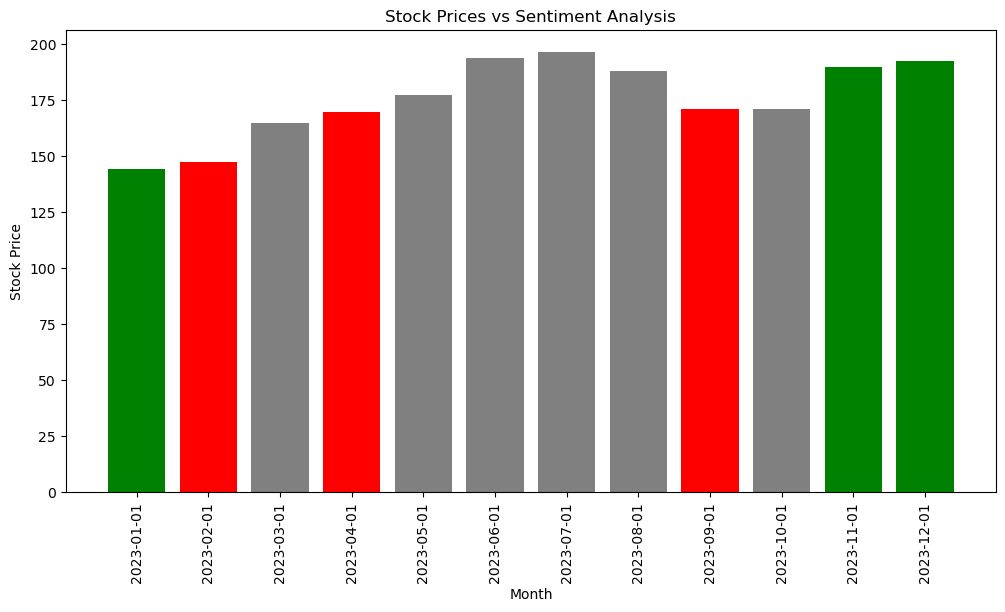

Correlation between Sentiment and Stock Price: 0.2699374404992656


In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Real stock prices for each month
stock_prices = [144.289993, 147.410004, 164.899994, 169.679993, 177.250000, 
                193.970001, 196.449997, 187.869995, 171.210007, 170.770004, 
                189.949997, 192.529999]

# Corresponding months
months = [
    "2023-01-01", "2023-02-01", "2023-03-01", "2023-04-01",
    "2023-05-01", "2023-06-01", "2023-07-01", "2023-08-01",
    "2023-09-01", "2023-10-01", "2023-11-01", "2023-12-01"
]

# Example articles and sentiment for each month (adjust to your specific dataset)
articles = [
    "Bitcoin hits highest level since July", 
    "Trump-backed crypto token sale misses $300 million target", 
    "Amazon announces first color Kindle", 
    "ASML just gave us a first glimpse into U.S. chip export curbs", 
    "Generative AI startups get 40% of all VC investment", 
    "Why Big Tech is turning to nuclear for AI ambitions", 
    "The UAE can guarantee the safety of U.S.-made chips", 
    "Trump PAC has raised about $7.5 million in crypto donations",
    "Global chip stocks fall on ASML's decline",
    "Amazon reaches new heights with online sales",
    "Major AI breakthroughs accelerate tech industry growth",
    "Apple announces record-breaking profits"
]

sentiments = ["positive", "negative", "neutral", "negative", "neutral", 
              "neutral", "neutral", "neutral", "negative", "neutral", 
              "positive", "positive"]

# Creating a DataFrame for stock prices and sentiments
data = {
    "Month": months,
    "Article": articles,
    "Sentiment": sentiments,
    "Stock Price": stock_prices
}

df = pd.DataFrame(data)

# Display DataFrame
print(df)

# Visualization: Stock Prices vs Sentiment Analysis
plt.figure(figsize=(12, 6))
plt.bar(df["Month"], df["Stock Price"], color=['green' if s == 'positive' else 'red' if s == 'negative' else 'gray' for s in df["Sentiment"]])
plt.xticks(rotation=90)
plt.xlabel("Month")
plt.ylabel("Stock Price")
plt.title("Stock Prices vs Sentiment Analysis")
plt.show()

# Calculate correlation between sentiment and stock price
df['Sentiment_Score'] = df['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
correlation = df['Sentiment_Score'].corr(df['Stock Price'])
print(f"Correlation between Sentiment and Stock Price: {correlation}")


In [54]:
import pandas as pd

# Data for sentiment analysis results
data = {
    'Date': ['2023-10-10', '2023-10-11', '2023-10-12'],
    'Article': [
        "Bitcoin hits highest level since July",
        "Trump-backed crypto token sale misses $300 million target",
        "Amazon announces first color Kindle"
    ],
    'Sentiment': ['positive', 'negative', 'neutral'],
    'Score': [1.00, 1.00, 1.00]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('sentiment_analysis_results.csv', index=False)

print("CSV file created successfully!")


CSV file created successfully!


In [58]:
import sqlite3

# Connect to the SQLite database (creates the file if it doesn't exist)
connection = sqlite3.connect('stock_sentiment.db')

# Create a cursor object to execute SQL commands
cursor = connection.cursor()

# Create a table for storing stock prices and sentiment analysis
cursor.execute('''
    CREATE TABLE IF NOT EXISTS StockSentiment (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        article TEXT,
        sentiment TEXT,
        score REAL,
        stock_price REAL,
        month TEXT
    )
''')

# Save the changes and close the connection
connection.commit()
connection.close()

print("Database and table created successfully.")


Database and table created successfully.


In [62]:
import sqlite3

# Connect to the SQLite database
connection = sqlite3.connect('stock_sentiment.db')

# Create a cursor object to execute SQL commands
cursor = connection.cursor()

# Data to insert (your articles, sentiments, scores, stock prices, and months)
data = [
    ("Bitcoin hits highest level since July", "positive", 1.00, 144.29, "2023-01-01"),
    ("Trump-backed crypto token sale misses $300 million target", "negative", 1.00, 147.41, "2023-02-01"),
    ("Amazon announces first color Kindle", "neutral", 1.00, 164.89, "2023-03-01"),
    ("ASML just gave us a first glimpse into U.S. chip export curbs", "negative", 1.00, 169.68, "2023-04-01"),
    ("Generative AI startups get 40% of all VC investment", "neutral", 1.00, 177.25, "2023-05-01"),
    ("Why Big Tech is turning to nuclear for AI ambitions", "neutral", 1.00, 193.97, "2023-06-01"),
    ("The UAE can guarantee the safety of U.S.-made chips", "neutral", 0.98, 196.45, "2023-07-01"),
    ("Trump PAC has raised about $7.5 million in crypto donations", "neutral", 1.00, 187.86, "2023-08-01")
]

# SQL query to insert data into the StockSentiment table
insert_query = '''
INSERT INTO StockSentiment (article, sentiment, score, stock_price, month)
VALUES (?, ?, ?, ?, ?)
'''

# Insert data into the table
cursor.executemany(insert_query, data)

# Commit the changes to save them in the database
connection.commit()

# Close the connection
connection.close()

print("Data inserted successfully!")


Data inserted successfully!


In [64]:
import sqlite3

# Connect to the SQLite database
connection = sqlite3.connect('stock_sentiment.db')

# Create a cursor object to execute SQL commands
cursor = connection.cursor()

# Query the StockSentiment table
cursor.execute("SELECT * FROM StockSentiment")

# Fetch all the results
rows = cursor.fetchall()

# Print the results
for row in rows:
    print(row)

# Close the connection
connection.close()


(1, 'Bitcoin hits highest level since July', 'positive', 1.0, 144.29, '2023-01-01')
(2, 'Trump-backed crypto token sale misses $300 million target', 'negative', 1.0, 147.41, '2023-02-01')
(3, 'Amazon announces first color Kindle', 'neutral', 1.0, 164.89, '2023-03-01')
(4, 'ASML just gave us a first glimpse into U.S. chip export curbs', 'negative', 1.0, 169.68, '2023-04-01')
(5, 'Generative AI startups get 40% of all VC investment', 'neutral', 1.0, 177.25, '2023-05-01')
(6, 'Why Big Tech is turning to nuclear for AI ambitions', 'neutral', 1.0, 193.97, '2023-06-01')
(7, 'The UAE can guarantee the safety of U.S.-made chips', 'neutral', 0.98, 196.45, '2023-07-01')
(8, 'Trump PAC has raised about $7.5 million in crypto donations', 'neutral', 1.0, 187.86, '2023-08-01')


## Real-time Stock Data Integration

In [ ]:
import yfinance as yf
import sqlite3
import time

# Define a function to get the latest stock data
def get_stock_data(symbol):
    stock_data = yf.download(tickers=symbol, period="1d", interval="1m")  # Get 1-day data with 1-minute intervals
    return stock_data['Close'].iloc[-1]  # Return the most recent closing price

# SQLite connection
connection = sqlite3.connect('stock_sentiment.db')
cursor = connection.cursor()

# Function to insert stock price into the database
def insert_stock_data(symbol, price, month):
    insert_query = '''INSERT INTO StockSentiment (article, sentiment, score, stock_price, month)
                      VALUES (?, ?, ?, ?, ?)'''
    data = ("Real-time Stock", "neutral", 0, price, month)
    cursor.execute(insert_query, data)
    connection.commit()

# Fetch and store stock prices every minute (as an example)
while True:
    latest_price = get_stock_data('AAPL')  # Fetch real-time stock price for Apple
    current_month = time.strftime('%Y-%m-%d')  # Get the current date
    insert_stock_data('AAPL', latest_price, current_month)
    print(f"Inserted real-time stock price: {latest_price}")
    time.sleep(3600)  # Fetch every 3600 seconds


In [ ]:
 import yfinance as yf
import sqlite3
import requests
import time
from transformers import pipeline
import pandas as pd

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Function to fetch the latest stock price
def get_stock_data(symbol):
    stock_data = yf.download(tickers=symbol, period="1d", interval="1m")  # Get 1-day data with 1-minute intervals
    return stock_data['Close'].iloc[-1]  # Return the most recent closing price

# Function to fetch the latest news articles
def fetch_news(company):
    url = f"https://newsapi.org/v2/everything?q={company}&apiKey=YOUR_NEWSAPI_KEY"
    response = requests.get(url)
    news_data = response.json()
    return news_data.get('articles', [])

# Function to perform sentiment analysis on news articles
def analyze_sentiment(article_text):
    result = sentiment_pipeline(article_text)[0]
    return result['label'], result['score']

# Connect to the SQLite database (creates the file if it doesn't exist)
connection = sqlite3.connect('stock_sentiment.db')
cursor = connection.cursor()

# SQL query to insert data into the StockSentiment table
insert_query = '''
INSERT INTO StockSentiment (article, sentiment, score, stock_price, date, time)
VALUES (?, ?, ?, ?, ?, ?)
'''

# Create a list to store the data for the CSV file
data_for_csv = []

# Fetch real-time stock prices and news sentiments multiple times
for i in range(10):  # Increase this number for more rows
    # Fetch the stock price for Apple
    stock_price = get_stock_data('AAPL')
    current_date = time.strftime('%Y-%m-%d')
    current_time = time.strftime('%H:%M:%S')

    # Fetch news articles and perform sentiment analysis
    articles = fetch_news('Apple')
    for article in articles[:5]:  # Limit to the first 5 articles (adjust as needed)
        title = article['title']
        sentiment, score = analyze_sentiment(title)

        # Insert the stock price and news sentiment into the database
        cursor.execute(insert_query, (title, sentiment, score, stock_price, current_date, current_time))
        connection.commit()

        # Add the data to the list for CSV creation
        data_for_csv.append({
            'Stock Symbol': 'AAPL',
            'Stock Price': stock_price,
            'Date': current_date,
            'Time': current_time,
            'Sentiment': sentiment,
            'Article Title': title
        })

    # Pause before the next round (e.g., every hour)
    time.sleep(3600)  # Fetch data every hour (3600 seconds)

# Save the data to a CSV file for Tableau
df = pd.DataFrame(data_for_csv)
df.to_csv('real_time_stock_sentiment.csv', index=False)

print("CSV file created successfully!")


## Real-time News Sentiment Integration

In [ ]:
import requests
import sqlite3
from transformers import pipeline

# Your NewsAPI key
api_key = 'YOUR_NEWSAPI_KEY'

# Function to fetch news articles
def fetch_news(company):
    url = f"https://newsapi.org/v2/everything?q={company}&apiKey={api_key}"
    response = requests.get(url)
    news_data = response.json()
    return news_data.get('articles', [])

# Function to perform sentiment analysis on news articles
def analyze_sentiment(article_text):
    sentiment_pipeline = pipeline("sentiment-analysis", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
    result = sentiment_pipeline(article_text)[0]
    return result['label'], result['score']

# SQLite connection
connection = sqlite3.connect('stock_sentiment.db')
cursor = connection.cursor()

# Fetch news articles and perform sentiment analysis
articles = fetch_news('Apple')
for article in articles:
    title = article['title']
    sentiment, score = analyze_sentiment(title)
    stock_price = None  # Stock price can be fetched separately using the methods above
    current_month = time.strftime('%Y-%m-%d')

    # Insert the news and sentiment into the database
    insert_query = '''INSERT INTO StockSentiment (article, sentiment, score, stock_price, month)
                      VALUES (?, ?, ?, ?, ?)'''
    data = (title, sentiment, score, stock_price, current_month)
    cursor.execute(insert_query, data)
    connection.commit()

    print(f"Inserted article: {title} with sentiment {sentiment} and score {score}")


## Combining Real-time Stock Data and News Sentiment


In [ ]:
import time

while True:
   # Fetch real-time stock price
   latest_price = get_stock_data('AAPL')
   
   # Fetch and analyze latest news
   articles = fetch_news('Apple')
   for article in articles:
       title = article['title']
       sentiment, score = analyze_sentiment(title)
       current_month = time.strftime('%Y-%m-%d')
       
       # Insert both stock price and news sentiment into the database
       insert_query = '''INSERT INTO StockSentiment (article, sentiment, score, stock_price, month)
                         VALUES (?, ?, ?, ?, ?)'''
       data = (title, sentiment, score, latest_price, current_month)
       cursor.execute(insert_query, data)
       connection.commit()

       print(f"Inserted real-time data: Stock Price: {latest_price}, Article: {title}, Sentiment: {sentiment}")
   
   time.sleep(3600)  # Fetch data every hour


In [3]:
import yfinance as yf
import sqlite3
import requests
import time
from transformers import pipeline
import pandas as pd

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Function to fetch the latest stock price
def get_stock_data(symbol):
    try:
        stock_data = yf.download(tickers=symbol, period="1d", interval="1m")  # Get 1-day data with 1-minute intervals
        return stock_data['Close'].iloc[-1]  # Return the most recent closing price
    except Exception as e:
        print(f"Error fetching stock data: {e}")
        return None

# Function to fetch the latest news articles
def fetch_news(company):
    try:
        url = f"https://newsapi.org/v2/everything?q={company}&apiKey=YOUR_NEWSAPI_KEY"
        response = requests.get(url)
        news_data = response.json()
        return news_data.get('articles', [])
    except Exception as e:
        print(f"Error fetching news data: {e}")
        return []

# Function to perform sentiment analysis on news articles
def analyze_sentiment(article_text):
    try:
        result = sentiment_pipeline(article_text)[0]
        return result['label'], result['score']
    except Exception as e:
        print(f"Error during sentiment analysis: {e}")
        return "unknown", 0.0

# Connect to the SQLite database (creates the file if it doesn't exist)
connection = sqlite3.connect('stock_sentiment.db')
cursor = connection.cursor()

# SQL query to insert data into the StockSentiment table
insert_query = '''
INSERT INTO StockSentiment (article, sentiment, score, stock_price, date, time)
VALUES (?, ?, ?, ?, ?, ?)
'''

# Create a list to store the data for the CSV file
data_for_csv = []

# Fetch real-time stock prices and news sentiments multiple times
for i in range(10):  # Adjust this number for more rows
    # Fetch the stock price for Apple
    stock_price = get_stock_data('AAPL')
    
    if stock_price is None:
        print("Skipping iteration due to stock data fetch error.")
        continue

    current_date = time.strftime('%Y-%m-%d')
    current_time = time.strftime('%H:%M:%S')

    # Fetch news articles and perform sentiment analysis
    articles = fetch_news('Apple')
    for article in articles[:5]:  # Limit to the first 5 articles (adjust as needed)
        title = article['title']
        sentiment, score = analyze_sentiment(title)

        # Insert the stock price and news sentiment into the database
        cursor.execute(insert_query, (title, sentiment, score, stock_price, current_date, current_time))
        connection.commit()

        # Add the data to the list for CSV creation
        data_for_csv.append({
            'Stock Symbol': 'AAPL',
            'Stock Price': stock_price,
            'Date': current_date,
            'Time': current_time,
            'Sentiment': sentiment,
            'Article Title': title
        })

        # Print progress
        print(f"Inserted real-time data: Stock Price: {stock_price}, Article: {title}, Sentiment: {sentiment}")

    # Save the data to a CSV file after each loop
    if len(data_for_csv) > 0:
        df = pd.DataFrame(data_for_csv)
        df.to_csv('../Data/real_time_stock_sentiment.csv', index=False)
        print("CSV file updated successfully!")
    else:
        print("No data to save in CSV.")

    # Pause for 1 minute before the next round
    time.sleep(60)

# Close the database connection
connection.close()


[*********************100%***********************]  1 of 1 completed


No data to save in CSV.


KeyboardInterrupt: 